In [76]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

##### Чтение данных

In [77]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [78]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [79]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [80]:
from sklearn.preprocessing import FunctionTransformer
def GetDummies(df):
    criteria_max = np.where(np.array(df.loc[:,:].max()==1))
    criteria_min = np.where(np.array(df.loc[:,:].max()==0))
    criteria_max = np.where(np.array(df.loc[:,:].max()==1))[0]
    criteria_min = np.where(np.array(df.loc[:,:].min()==0))[0]
    bin_cols = [i for i in criteria_max if i in criteria_min]
    # добавим столбцы, которые тоже нужно удалить
    a = ['RowNumber','CustomerId','Surname']
    a_list = [list(df.columns).index(i) for i in a]
    for i in a_list:
        bin_cols.append(i)
    categorical = df.select_dtypes(include='object').columns#.drop('Surname')
    categorical = categorical.drop('Surname')
    categorical = [i for i in categorical if i not in df.columns[bin_cols]]
    global numerical
    numerical = df.select_dtypes(exclude='object').columns.drop(['RowNumber', 'CustomerId'])
    numerical = [i for i in numerical if i not in df.columns[bin_cols].values]    
    df_new = pd.get_dummies(df[categorical],columns=categorical,prefix=categorical)
    df_new[numerical] = df[numerical]
    return df_new

def scalaring(df):
    std_scaler = StandardScaler()
    df[numerical] = std_scaler.fit_transform(df[numerical])
    return df


GetDummies_transformer = FunctionTransformer(GetDummies)
scalaring_transformer = FunctionTransformer(scalaring)

pipeline_transformer = Pipeline([('get_dummies',GetDummies_transformer),('scalaring',scalaring_transformer)])
pipeline_classifier = Pipeline([('transformer',pipeline_transformer),('classifier',GradientBoostingClassifier(random_state = 42))])

In [81]:
from sklearn.model_selection import GridSearchCV
gs_model = GridSearchCV(estimator = pipeline_classifier, param_grid = {'classifier__learning_rate':[0.01],\
                                                                       'classifier__n_estimators':[1000],\
                                                                       'classifier__max_depth':[3,5,7],\
                                                                       'classifier__criterion':['mse']})
gs_model.fit(X_train,y_train)
y_hat = gs_model.predict_proba(X_test)[:,1]


In [82]:
precision,recall,thresholds = precision_recall_curve(y_test,y_hat)
f_score = (precision**2)*recall/(precision+recall)
ix = np.argmax(f_score)
threshold = thresholds[ix]
print('f_score',f_score[ix],'\nprecision',precision[ix],'\nrecall',recall[ix],'\nthreshold',threshold)

f_score 0.21628039426424525 
precision 0.7833935018050542 
recall 0.4263261296660118 
threshold 0.5559574930618639


Отрисуем матрицу ошибок

In [83]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1931   60]
 [ 293  216]]


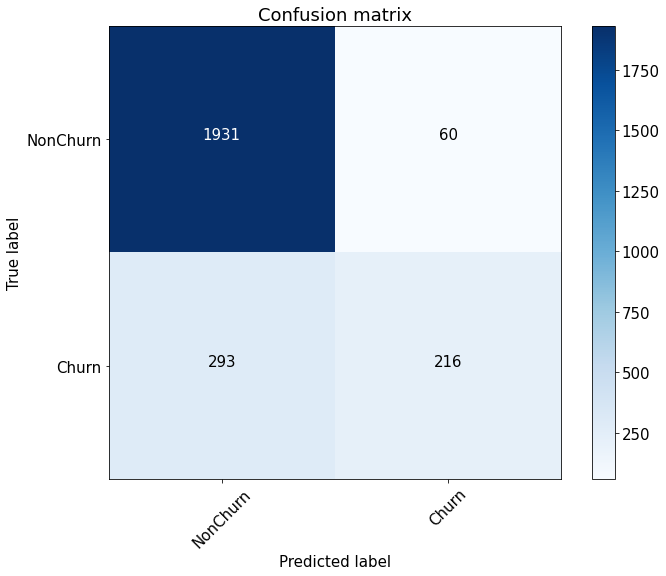

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1991
           1       0.78      0.42      0.55       509

    accuracy                           0.86      2500
   macro avg       0.83      0.70      0.73      2500
weighted avg       0.85      0.86      0.84      2500



In [84]:
from sklearn.metrics import confusion_matrix, classification_report
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_hat>threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_rfc.png")
plt.show()
print(classification_report(y_test, y_hat>threshold))

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

In [85]:
##### GBC + GridSearchCV
print('\nGBC + GridSearchCV')
df_result = pd.DataFrame(y_hat>threshold,y_test).reset_index().set_index(X_test.index)
df_result.head()
TP = df_result.loc[(df_result['Exited']==df_result[0])&(df_result[0]==1),:].count()[0] # действительно положительные
FP = df_result.loc[(df_result['Exited']!=df_result[0])&(df_result[0]==1),:].count()[0] # ложно положительные
TN = df_result.loc[(df_result['Exited']==df_result[0])&(df_result[0]==0),:].count()[0] # действительно отрицательные
FN = df_result.loc[(df_result['Exited']!=df_result[0])&(df_result[0]==0),:].count()[0] # ложно отрицательные
print(f'TP = {TP},\nFP = {FP},\nTN = {TN},\nFN = {FN}')
print(f'Затраты составили: {1*(TP+FP)}')
print(f'Доходы составили: {2*TP}')
print(f'Прибыль составила: {2*TP - 1*(TP+FP)}')


GBC + GridSearchCV
TP = 216,
FP = 60,
TN = 1931,
FN = 293
Затраты составили: 276
Доходы составили: 432
Прибыль составила: 156
